# Chapter 2: Multi-armed Bandits
Neel Shah, 2021  
**Solutions are not guaranteed to be correct**

**Exercise 2.1 In $\epsilon$-greedy action selection, for the case of two actions and $\epsilon$ = 0.5, what is the probability that the greedy action is selected?**  
.5 * 1 (exploit case) + .5 * .5 (explore case) = .75

**Exercise 2.2: Bandit example Consider a k-armed bandit problem with k = 4 actions, denoted 1, 2, 3, and 4. Consider applying to this problem a bandit algorithm using "-greedy action selection, sample-average action-value estimates, and initial estimates of Q1(a) = 0, for all a. Suppose the initial sequence of actions and rewards is A1 = 1, R1 =-1,A2 =2,R2 =1,A3 =2,R3 =-2,A4 =2,R4 =2,A5 =3,R5 =0. Onsome of these time steps the " case may have occurred, causing an action to be selected at random. On which time steps did this definitely occur? On which time steps could this possibly have occurred?**  
Definitely:  
4 - Q(2) is < 0 while Q(3), Q(4) = 0 so choosing A=2 must be a random choice (after Q(2)=1)  
5 - Q(3) = 0 but Q(2) > 0, so choosing action 3 must be random  
Possible:   
1 - all Q_1's = 0 which means that R1 can either be explore or picking one such action (after Q(1) = -1)  
2 - Q_1(1) = -1, rest are 0, so this choice could be random or picking one such Q(2) = 0  
3 - now, Q(2) = 1, so choosing 2 can be random choice or exploitation (after Q(2) = -.5)  

**Exercise 2.3 In the comparison shown in Figure 2.2, which method will perform best in the long run in terms of cumulative reward and probability of selecting the best action? How much better will it be? Express your answer quantitatively.**  
$$
\epsilon=.01
$$
As $t\rightarrow\inf$, the probability of selecting the optimal action approaches $1-\epsilon=.99$



Normally, $$Q_n = \frac{R_1 + ... + R_{n-1}}{n-1}$$ However, each additional reward would require additionally memory to store it and computation to compute the sum.  
Instead, we can devise a way to incrementally update.  Given $Q_n$ and the $n$th reward $R_n$, 
$$
\begin{align*}
Q_{n+1} &= \frac{1}{n}\sum_{i=1}^{n}R_i  \\
&= \frac{1}{n}\left(R_n + \sum{i=1}_{n-1}R_i\right)  \\
&= \frac{1}{n}\left(R_n + (n-1)\frac{1}{n-1}\sum{i=1}_{n-1}R_i\right)  \\
&= \frac{1}{n}\big(R_n + (n-1)Q_n\big)  \\
&= \frac{1}{n}\big(R_n + nQ_n - Q_n\big)  \\
&= Q_n + \frac{1}{n}[R_n - Q_n]  
\end{align*}
$$
This implementation requires memory only for $Q_n$ and $n$ and slight computation for each new reward. $$ NewEstimate \leftarrow OldEstimate + StepSize [Target - OldEstimate] $$

**Exercise 2.4 If the step-size parameters, $\alpha_n$, are not constant, then the estimate $Q_n$ is a weighted average of previously received rewards with a weighting different from that given by (2.6). What is the weighting on each prior reward for the general case, analogous to (2.6), in terms of the sequence of step-size parameters?**  
$$
\begin{align}
Q_{n+1} &= Q_n + \alpha_n\left[R_n - Q_n\right] \\
&= \alpha_nR_n + \left(1 - \alpha_n\right)Q_n \\
&= \alpha_nR_n + (1-\alpha_n)\left[\alpha_{n-1}R_{n-1} + (1-\alpha_{n-1}Q_{n-1}\right] \\
&= \alpha_nR_n + (1-\alpha_n)\alpha_{n-1}R_{n-1} + (1-\alpha_n)(1-\alpha_{n-1}Q_{n-1})\\
&= ... \\
&= Q_1\prod_{i=1}^{n}(1-\alpha_i) + \sum_{i=0}^{n}\left(R_{n-i}\alpha_{n-i}\prod_{j=0}^{i-1}\left(1-\alpha_{n-j}\right)\right)
\end{align}
$$

**Exercise 2.5 (programming) Design and conduct an experiment to demonstrate the difficulties that sample-average methods have for nonstationary problems. Use a modified version of the 10-armed testbed in which all the $q_{\star}(a)$ start out equal and then take independent random walks (say by adding a normally distributed increment with mean 0 and standard deviation 0.01 to all the $q_{\star}(a)$ on each step). Prepare plots like Figure 2.2 for an action-value method using sample averages, incrementally computed, and another action-value method using a constant step-size parameter, $\alpha = 0.1$. Use $\epsilon = 0.1$ and longer runs, say of 10,000 steps.**. 

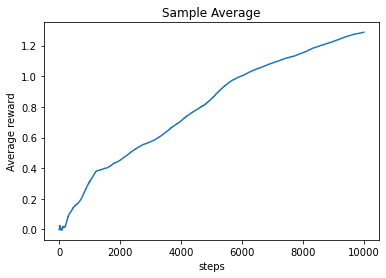

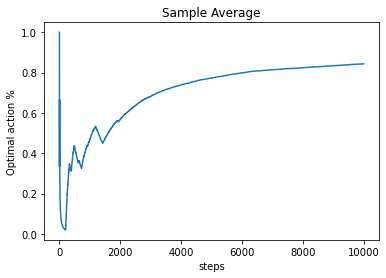

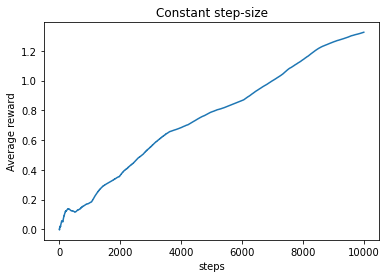

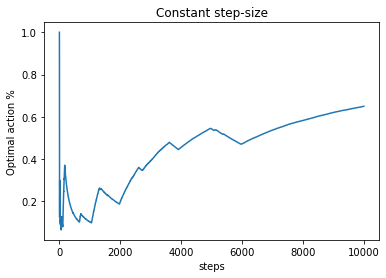

In [22]:
import numpy as np
from typing import List, Callable
import matplotlib.pyplot as plt
#10-armed bandit

#expected reward for action a
q_star = [0 for _ in range(10)]

def sample_average_bandit(steps: int, 
                          eps: float, 
                          rewards: Callable, 
                          num_actions: int = 10, 
                          analyze: Callable = None, q=None):
    """Sample average bandit"""
    #initial guess of rewards
    q = q or [0 for _ in range(num_actions)]
    n = [0 for _ in range(num_actions)]
    for step in range(1,steps+1):
        if np.random.random() < eps:
            action = np.random.randint(0, num_actions)
        else:
            action = np.argmax(q)
        reward = rewards(action)
        n[action] += 1
        q[action] = q[action] + (1/n[action]) * (reward - q[action])
        if analyze is not None:
            analyze(step, eps, action, reward)
            
def constant_step_bandit(steps: int, 
                         eps: float, 
                         rewards: Callable, 
                         step_size: float,
                         num_actions: int = 10, 
                         analyze: Callable = None, q=None):
    """Constant step bandit"""
    #initial guess of rewards
    q = q or [0 for _ in range(num_actions)]
    for step in range(1,steps+1):
        if np.random.random() < eps:
            action = np.random.randint(0, num_actions)
        else:
            action = np.argmax(q)
        reward = rewards(action)
        q[action] = q[action] + step_size * (reward - q[action])
        if analyze is not None:
            analyze(step, eps, action, reward)
            

def gen_funcs(q_star: List[float]):
    q = q_star.copy()
    optimal = -1
    def rewards(action: int):
        nonlocal q, optimal
        optimal = np.argmax(q)
        reward = q[action]
        q = q + np.random.normal(0, .01, 10)
        return reward
    
    class analyze:
        def __init__(self):
            self.step = 1
            self.rewards = 0
            self.average_reward = []
            self.optimal_actions = 0
            self.optimal_action_perc = []

        def __call__(self, step, epsilon, action, reward):
            self.step = step
            self.rewards += reward
            self.average_reward.append(self.rewards/self.step)
            self.optimal_actions += 1 if action == optimal else 0
            self.optimal_action_perc.append(self.optimal_actions/self.step)
        
        def plot(self, label):
            fig, ax = plt.subplots()
            ax.plot(np.arange(self.step), self.average_reward)
            ax.set(xlabel='steps', ylabel='Average reward', title=label)
            plt.show()
            
            fig, ax = plt.subplots()
            ax.plot(np.arange(self.step), self.optimal_action_perc)
            ax.set(xlabel='steps', ylabel='Optimal action %', title=label)
            plt.show()
            
    return rewards, analyze

rewards, analyze = gen_funcs(q_star)
analyze_obj = analyze()
sample_average_bandit(10000, .1, rewards, 10, analyze_obj)
analyze_obj.plot('Sample Average')

rewards, analyze = gen_funcs(q_star)
analyze_obj = analyze()
constant_step_bandit(10000, .1, rewards, .1, 10, analyze_obj)
analyze_obj.plot('Constant step-size')

**Exercise 2.6: Mysterious Spikes The results shown in Figure 2.3 should be quite reliable because they are averages over 2000 individual, randomly chosen 10-armed bandit tasks. Why, then, are there oscillations and spikes in the early part of the curve for the optimistic method? In other words, what might make this method perform particularly better or worse, on average, on particular early steps?**  
  $\epsilon = 0$ implies that will always choose the action that it thinks is optional, with ties broken randomly. With all $Q_1(a) = 5 \forall a$ the top choice initially has a $1/10$ probability of being chosen and so-forth once $Q_i(a)$ is updated.  
**Exercise 2.7: Unbiased Constant-Step-Size Trick In most of this chapter we have used sample averages to estimate action values because sample averages do not produce the initial bias that constant step sizes do (see the analysis leading to (2.6)). However, sample averages are not a completely satisfactory solution because they may perform poorly on nonstationary problems. Is it possible to avoid the bias of constant step sizes while retaining their advantages on nonstationary problems? One way is to use a step size of
$$\beta_{n}=\alpha/\bar{o}_n$$, (2.8) to process the nth reward for a particular action, where $\alpha>0$ is a conventional constant
step size, and $\bar{o}_n$ is a trace of one that starts at 0:
$$\bar{o}_n=\bar{o}_{n-1}+\alpha(1-\bar{o}_{n-1})$$, for $n\geq0$, with $\bar{o}_0=0$ (2.9)  
Carry out an analysis like that in (2.6) to show that Qn is an exponential recency-weighted average without initial bias.**
$$
\begin{align*}
\bar{o}_n &= \bar{o}_{n-1} + \alpha(1-\bar{o}_{n-1}) \\
&= \bar{o}_{n-1} + \alpha - \alpha\bar{o}_{n-1} \\
&= \alpha + (1-\alpha)(\alpha + (1-\alpha)\bar{o}_{n-2}) \\
&= \alpha + (1-\alpha)\alpha + (1-\alpha)^2(\alpha + (1-\alpha)\bar{o}_{n-3}) \\
&= \sum_{i=0}^{n}(1-\alpha)^i\alpha \\
&= \alpha\left(\frac{1-(1-\alpha)^{n+1}}{\alpha}\right) \\
&= 1 - (1-\alpha)^{n+1}
\end{align*}
$$
Because $\bar{o}_n$ is a geometric series which converges at 1 (not shown), the bandit has initial bias to promote exploration, but the step-size $\beta_n$ decreases, eventually converging to a constant step-size $\alpha$

**Exercise 2.8: UCB Spikes In Figure 2.4 the UCB algorithm shows a distinct spike in performance on the 11th step. Why is this? Note that for your answer to be fully satisfactory it must explain both why the reward increases on the 11th step and why it decreases on the subsequent steps. Hint: If c = 1, then the spike is less prominent.**  
$N_t(a)=0\space \forall a$ until step 11. At step 11, because all $N_t(a)$ are equal (at that point), the algorithm chooses the action that it predicts the highest reward. For subsequent steps, $N_t(a) > 1$ so the confidence level term decreases causing more actions to be explored and reward estimates to be updated.

**Exercise 2.9 Show that in the case of two actions, the soft-max distribution is the same as that given by the logistic, or sigmoid, function often used in statistics and artificial neural networks.**  
*TODO*
  
**Exercise 2.10 Suppose you face a 2-armed bandit task whose true action values change randomly from time step to time step. Specifically, suppose that, for any time step, the true values of actions 1 and 2 are respectively 10 and 20 with probability 0.5 (case A), and 90 and 80 with probability 0.5 (case B). If you are not able to tell which case you face at any step, what is the best expected reward you can achieve and how should you behave to achieve it? Now suppose that on each step you are told whether you are facing case A or case B (although you still don’t know the true action values). This is an associative search task. What is the best expected reward you can achieve in this task, and how should you behave to achieve it?**  
Regular bandit:  
max expected reward $.5*10+.5*90 = 50 = .5*20+.5*80$, you can achieve this only by assuming that all cases are consistent (don't switch between guessing case A and B) and choosing the same action
Contextual bandit:
max expected reward 20 in case A and 90 in case B. You can learn the rewards for actions for each tasks independently.


**Exercise 2.11 (programming) Make a figure analogous to Figure 2.6 for the nonstationary case outlined in Exercise 2.5. Include the constant-step-size "-greedy algorithm with ↵=0.1. Use runs of 200,000 steps and, as a performance measure for each algorithm and parameter setting, use the average reward over the last 100,000 steps.**
*Not fully implemented below* 

/Users/neel/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:61: RuntimeWarning: invalid value encountered in true_divide
/Users/neel/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:61: RuntimeWarning: divide by zero encountered in true_divide


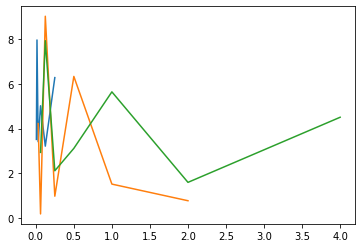

In [31]:
from scipy.special import softmax

eps = [1/128, 1/64, 1/32, 1/16, 1/8, 1/4]
alphas = [1/32,1/16,1/8,1/4,1/2,1,2]
cs = [1/16,1/8,1/4,1/2,1,2,4]
q0s = [1/4,1/2,1,2,4]

def gen_rewards(q_star: List[float]):
    q = q_star.copy()
    optimal = -1
    def rewards(action: int):
        nonlocal q, optimal
        optimal = np.argmax(q)
        reward = q[action]
        q = q + np.random.normal(0, .01, 10)
        return reward
    return rewards

class analyze:
    d = {}
    def __init__(self, alg):
        self.alg = alg
        if alg not in analyze.d:
            analyze.d[alg] = {}
        self.sum = 0
    
    def __call__(self, *args):
        if len(args) == 3:
            self._call(args[0], args[1], args[2])
        elif len(args) == 4:
            self._call_eps(args[0], args[1], args[2], args[3])
    def _call(self, step, param, reward):
        if step > 100000:
            self.sum += reward
            if step == 200000:
                analyze.d[self.alg][param] = self.sum/100000

    def _call_eps(self, step, eps, action, reward):
        """call for greedy algs"""
        if step > 100000:
            self.sum += reward
            if step == 200000:
                analyze.d[self.alg][eps] = self.sum/100000
    def plot():
        fig, ax = plt.subplots()
        for alg in analyze.d:
            ax.plot(analyze.d[alg].keys(), analyze.d[alg].values(), label=alg)
        plt.show()

def ucb(steps: int, 
        c: float, 
        rewards: Callable, 
        num_actions: int = 10, 
        analyze: Callable = None, 
        q=None):
    """UCB Action selection"""
    #initial guess of rewards
    q = q or [0 for _ in range(num_actions)]
    n = [0 for _ in range(num_actions)]
    for step in range(1,steps+1):
        action = np.argmax(q + c*np.sqrt(np.log(step)/n))
        reward = rewards(action)
        n[action] += 1
        q[action] = q[action] + (1/n[action]) * (reward - q[action])
        if analyze is not None:
            analyze(step, c, reward)

def gradient_bandit(steps: int, 
                    rewards: Callable, 
                    step_size: float,
                    num_actions: int = 10, 
                    analyze: Callable = None, 
                    q=None):
    """Gradient bandit"""
    #initial guess of rewards
    q = q or [0 for _ in range(num_actions)]
    H = [0 for _ in range(num_actions)] #preference parameter
    R = 0
    for step in range(1,steps+1):
        probs = softmax(H)
        action = np.random.choice(num_actions, p=probs)
        reward = rewards(action)
        for a in range(num_actions):
            if a == action:
                H[a] = H[a] + step_size*(reward - R)*(1-probs[a])
            else:
                H[a] = H[a] - step_size*(reward - R)*probs[a]
            R = R + (1/step)*(reward - R)
        if analyze is not None:
            analyze(step, step_size, reward)

for e in eps:
    rewards = gen_rewards(q_star)
    analyze_obj = analyze('eps-greedy')
    constant_step_bandit(200000, e, rewards, .1, 10, analyze_obj)

for a in alphas:
    rewards = gen_rewards(q_star)
    analyze_obj = analyze('gradient bandit')
    gradient_bandit(200000, rewards, a, 10, analyze_obj)

for c in cs:
    rewards = gen_rewards(q_star)
    analyze_obj = analyze('UCB')
    ucb(200000, c, rewards, 10, analyze_obj)

for q0 in q0s:
    rewards = gen_rewards(q_star)
    analyze_obj = analyze('greedy with optimistic initialization alpha=.1')
    constant_step_bandit(200000, 0, rewards, .1, 10, analyze_obj, [q0]*10)

analyze.plot()